In [4]:
import os
import sys
import json
import pickle

import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import pandas as pd

import functools

import numpy as np
import math
import random
import scipy
import yaml

parent_dir = Path().resolve().parent
sys.path.insert(0, str(parent_dir))
import plotting
import utils

2025-09-11 14:39:23.049110: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1757594363.061353  273860 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1757594363.065078  273860 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1757594363.074682  273860 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1757594363.074694  273860 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1757594363.074695  273860 computation_placer.cc:177] computation placer alr

In [5]:
CONFIG_FILE = '../configs/esann25/experiment_config.json'
EMB_SIZE_LOOKUP = {'text-embedding-3-small': 1536,
                   'text-embedding-3-large': 3072,
                   'google/electra-base-generator': 256,
                   'albert-base-v2': 768,
                   'distilbert-base-uncased': 768,
                   'gpt2': 768,
                   'bert-base-uncased': 768,
                   'roberta-base': 768,
                   'bert-large-uncased': 1024,
                   'roberta-large': 1024,
                   'gpt2-large': 1280,
                   'google/electra-base-discriminator': 768
                  }

## Setup

In [6]:
with open(CONFIG_FILE, 'r') as f:
    config = json.load(f)

openai_models = config["openai_models"]
huggingface_models = config["huggingface_models"]
models = huggingface_models + openai_models

In [7]:
results_cav = pd.read_csv('../../'+config['results_dir']+config['cav_results_file'])
results_cbm = pd.read_csv('../../'+config['results_dir']+config['cbm_results_file'])
results_bias_space = pd.read_csv('../../'+config['results_dir']+config['bias_space_results_file'])

In [6]:
assert (results_cav.columns == results_cbm.columns).all() and (results_cav.columns == results_bias_space.columns).all()

In [7]:
results_cav

,protected_attr,dataset (train),dataset (eval),embedder,pooling,group (test),concept (train),F1,Pearson R,Pearson p
0,disability,jigsaw,jigsaw,google/electra-base-generator,mean,psychiatric_or_mental_illness,psychiatric_or_mental_illness,0.498246,0.020509,0.004836
1,disability,jigsaw,crows_pairs,google/electra-base-generator,mean,mental_disability_illness,mental_disability_illness,0.497250,0.021270,0.242900
2,disability,crows_pairs,jigsaw,google/electra-base-generator,mean,psychiatric_or_mental_illness,psychiatric_or_mental_illness,0.498246,0.019030,0.008934
3,disability,jigsaw,jigsaw,google/electra-base-generator,cls,psychiatric_or_mental_illness,psychiatric_or_mental_illness,0.498246,0.006434,0.376742
4,disability,jigsaw,crows_pairs,google/electra-base-generator,cls,mental_disability_illness,mental_disability_illness,0.497250,0.035191,0.053307
...,...,...,...,...,...,...,...,...,...,...
982,religion,jigsaw,crows_pairs,text-embedding-3-small,NaN,muslim,muslim,0.094225,0.641053,0.000000
983,religion,jigsaw,crows_pairs,text-embedding-3-small,NaN,jewish,jewish,0.094225,0.654136,0.000000
984,religion,crows_pairs,jigsaw,text-embedding-3-small,NaN,christian,christian,0.138553,0.586403,0.000000
985,religion,crows_pairs,jigsaw,text-embedding-3-small,NaN,muslim,muslim,0.138553,0.582028,0.000000


In [8]:
results_cbm

,protected_attr,dataset (train),dataset (eval),embedder,pooling,group (test),concept (train),F1,Pearson R,Pearson p
0,disability,jigsaw,jigsaw,google/electra-base-generator,mean,psychiatric_or_mental_illness,psychiatric_or_mental_illness,0.704472,0.216175,1.918148e-198
1,disability,jigsaw,crows_pairs,google/electra-base-generator,mean,psychiatric_or_mental_illness,psychiatric_or_mental_illness,0.587903,0.187630,2.684361e-25
2,disability,jigsaw,jigsaw,google/electra-base-generator,cls,psychiatric_or_mental_illness,psychiatric_or_mental_illness,0.498246,0.118902,2.143906e-60
3,disability,jigsaw,crows_pairs,google/electra-base-generator,cls,psychiatric_or_mental_illness,psychiatric_or_mental_illness,0.497250,0.030447,9.456349e-02
4,disability,jigsaw,jigsaw,albert-base-v2,mean,psychiatric_or_mental_illness,psychiatric_or_mental_illness,0.726664,0.223435,3.340392e-212
...,...,...,...,...,...,...,...,...,...,...
646,religion,jigsaw,jigsaw,text-embedding-3-small,NaN,buddhist,buddhist,0.610104,0.126206,7.181384e-68
647,religion,jigsaw,jigsaw,text-embedding-3-small,NaN,hindu,hindu,0.610104,0.114039,1.137663e-55
648,religion,jigsaw,crows_pairs,text-embedding-3-small,NaN,christian,christian,0.901199,0.675289,0.000000e+00
649,religion,jigsaw,crows_pairs,text-embedding-3-small,NaN,muslim,muslim,0.901199,0.669413,0.000000e+00


In [9]:
results_bias_space

,protected_attr,dataset (train),dataset (eval),embedder,pooling,group (test),concept (train),F1,Pearson R,Pearson p
0,disability,/,crows_pairs,google/electra-base-generator,mean,mental_disability_illness,mental illness,0,0.082806,5.276604e-06
1,disability,/,jigsaw,google/electra-base-generator,mean,psychiatric_or_mental_illness,mental illness,0,0.067944,9.189687e-21
2,disability,/,crows_pairs,google/electra-base-generator,cls,mental_disability_illness,mental illness,0,-0.012288,4.999267e-01
3,disability,/,jigsaw,google/electra-base-generator,cls,psychiatric_or_mental_illness,mental illness,0,0.022158,2.331418e-03
4,disability,/,crows_pairs,albert-base-v2,mean,mental_disability_illness,mental illness,0,0.003179,8.614675e-01
...,...,...,...,...,...,...,...,...,...,...
520,religion,/,jigsaw,text-embedding-3-small,NaN,buddhist,buddhist,0,0.091614,1.802192e-36
521,religion,/,jigsaw,text-embedding-3-small,NaN,hindu,hindu,0,0.054275,8.529794e-14
522,religion,/,crows_pairs,text-embedding-3-small,NaN,christian,christian,0,0.458370,1.376819e-156
523,religion,/,crows_pairs,text-embedding-3-small,NaN,muslim,muslim,0,0.564008,6.647304e-253


## Process results

In [10]:
# set concept method
res_bias_space = results_bias_space.copy()
res_bias_space['method'] = 'bias space'
res_cav = results_cav.copy()
res_cav['method'] = 'CAV'
res_cbm = results_cbm.copy()
res_cbm['method'] = 'CBM'

# merge results
res_all = pd.concat([res_bias_space, res_cav, res_cbm])
res_all = res_all.reset_index()

# fill empty pooling cells (openai models)
res_all.loc[:,'pooling'] = res_all.loc[:,'pooling'].fillna('unknown')

In [11]:
def get_model_architecture(model_name):
    if type(model_name) != str:
        return model_name
        
    if model_name in openai_models:
        return 'embedder' # presumably also encoder based
    if 'gpt' in model_name:
        return 'decoder'
    else:
        return 'encoder'

def get_model_type(model_name):
    if type(model_name) != str:
        return model_name
        
    if model_name in openai_models:
        return 'embedder'
    if 'gpt' in model_name or 'generator' in model_name:
        return 'generator'
    else:
        return 'discriminator'

res_all['model_type'] = [get_model_type(res_all.loc[i,'embedder']) for i in range(len(res_all))]
res_all['model_architecture'] = [get_model_architecture(res_all.loc[i,'embedder']) for i in range(len(res_all))]

def get_emb_size(model_name):
    # check model's emb size is saved in the lookup
    if not model_name in EMB_SIZE_LOOKUP.keys():
        if model_name in huggingface_models:
            # load model and get size
            lm = get_pretrained_model(model_name, 2, batch_size=1)
            EMB_SIZE_LOOKUP[model_name] = lm.model.config.hidden_size
        else:
            print("cannot query model size for %s, which is not in the list of huggingface models (set size to 0)")
            EMB_SIZE_LOOKUP[model_name] = 0

    return EMB_SIZE_LOOKUP[model_name]

res_all['emb_size'] = [get_emb_size(res_all.loc[i,'embedder']) for i in range(len(res_all))]
res_all

,index,protected_attr,dataset (train),dataset (eval),embedder,pooling,group (test),concept (train),F1,Pearson R,Pearson p,method,model_type,model_architecture,emb_size
0,0,disability,/,crows_pairs,google/electra-base-generator,mean,mental_disability_illness,mental illness,0.000000,0.082806,5.276604e-06,bias space,generator,encoder,256
1,1,disability,/,jigsaw,google/electra-base-generator,mean,psychiatric_or_mental_illness,mental illness,0.000000,0.067944,9.189687e-21,bias space,generator,encoder,256
2,2,disability,/,crows_pairs,google/electra-base-generator,cls,mental_disability_illness,mental illness,0.000000,-0.012288,4.999267e-01,bias space,generator,encoder,256
3,3,disability,/,jigsaw,google/electra-base-generator,cls,psychiatric_or_mental_illness,mental illness,0.000000,0.022158,2.331418e-03,bias space,generator,encoder,256
4,4,disability,/,crows_pairs,albert-base-v2,mean,mental_disability_illness,mental illness,0.000000,0.003179,8.614675e-01,bias space,discriminator,encoder,768
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2158,646,religion,jigsaw,jigsaw,text-embedding-3-small,unknown,buddhist,buddhist,0.610104,0.126206,7.181384e-68,CBM,embedder,embedder,1536
2159,647,religion,jigsaw,jigsaw,text-embedding-3-small,unknown,hindu,hindu,0.610104,0.114039,1.137663e-55,CBM,embedder,embedder,1536
2160,648,religion,jigsaw,crows_pairs,text-embedding-3-small,unknown,christian,christian,0.901199,0.675289,0.000000e+00,CBM,embedder,embedder,1536
2161,649,religion,jigsaw,crows_pairs,text-embedding-3-small,unknown,muslim,muslim,0.901199,0.669413,0.000000e+00,CBM,embedder,embedder,1536


In [12]:
# from a western-centric perspective (leaving white,male,christian as non-marginalized groups)
marginalized_groups = ['F', 'female', 'asian', 'black', 'latino', 'buddhist', 'hindu', 'jewish', 'muslim', 'mental_disability_illness', 'psychiatric_or_mental_illness']

# from a western/ US perspective / groups that appear infrequent in the datasets (TODO confirm and provide than threshold)
minority_groups = ['asian', 'latino', 'buddhist', 'hindu', 'mental_disability_illness', 'psychiatric_or_mental_illness']


## Utils

In [13]:
def aggregate_results(results, sel_cols, target_col):
    grouped_res = results.groupby(sel_cols, as_index=False)[target_col].mean().reset_index()
    grouped_res[target_col+' var'] = results.groupby(sel_cols, as_index=False)[target_col].var()[target_col]
    return grouped_res

In [14]:
def boxplot(results, ax, xcol, ycol, huecol, title, remove_legend=False, add_ylabel=False, ymin=-0.5, ymax=1.0):
    # mark 0 with hline
    ax.hlines(y=0, xmin=-1, xmax=6, linewidth=0.5, color='black')

    # do boxplot
    if huecol is not None:
        sns.boxplot(data=results, x=xcol, y=ycol, hue=huecol, ax=ax)
    else:
        sns.boxplot(data=res_dataset, x=xcol, y=ycol, ax=ax)

    # set title and labels/ change fontsize
    ax.set_title(title, fontsize=15)
    ax.set_xlabel('')
    if add_ylabel:
        ax.set_ylabel(ycol, fontsize=15)
    else:
        ax.set_ylabel('')
    ax.tick_params(axis='x', labelsize=15)
    
    # set lenged if required, set ylim to make space for legend
    ax.set_ylim(ymin, ymax)
    legend = ax.legend(fontsize=14)
    if remove_legend:
        legend.remove()

def multipot(results, subplot_col, xcol, ycol, huecol, remove_legend=False, savefile=None):
    # create a subplot for unique value in subplot_col
    subplot_choices = list(set(results.loc[:,subplot_col]))
    fig, axes = plt.subplots(1, len(subplot_choices), figsize=(5*len(subplot_choices), 4))

    # do boxplot for each value in subplot_col
    if len(subplot_choices) == 1:
        boxplot(results, axes, xcol=xcol, ycol=ycol, huecol=huecol, title=subplot_choices[0], add_ylabel=True)
    else:
        for i, val in enumerate(subplot_choices):
            res_filt = results.loc[results[subplot_col] == val]
            boxplot(res_filt, axes[i], xcol=xcol, ycol=ycol, huecol=huecol, title=val, add_ylabel=(i==0))

    # (save and) show figure
    if savefile is not None:
        if '.eps' in savefile:
            plt.savefig(savefile, format='eps', bbox_inches='tight')
        else:
            plt.savefig(savefile, bbox_inches='tight')
    plt.show()

## 1) Baseline: Linear Concept learning (CAV, CBM)

Report and plot F1-scores for CAV and CBM in the regular concept learning (train-test from same datasets) and concept transfer (to another dataset) setting. The concept learning serves as a baseline as it should reflect the best possible estimation of linear concepts in the language model's embeddings (assuming classifiers converge; given the available data). The concept transfer case shows how robust or dataset-specific the learned concepts are.

### a) Learning and testing on splits of the same dataset

In [15]:
res_cl = res_all[res_all['method'] != 'bias space']

# aggregate results of all groups of the same experiment run
gres = aggregate_results(res_cl, ['method', 'protected_attr', 'dataset (train)', 'dataset (eval)', 'pooling', 'embedder'], 'F1')

# add column to distinguish transfer and non-transfer cases
gres.loc[:, 'exp'] = ['transfer' if gres.loc[i, 'dataset (train)'] != gres.loc[i, 'dataset (eval)'] else '' for i in range(len(gres))]
gres_same_dataset = gres[gres['exp'] != 'transfer']

# summarize results per dataset and transfer/ non transfer
res_per_dataset_transfer = aggregate_results(gres_same_dataset, ['exp', 'dataset (eval)', 'method'], 'F1')
res_per_dataset_transfer

,index,exp,dataset (eval),method,F1,F1 var
0,0,,bios-supervised,CAV,0.913726,0.023002
1,1,,bios-supervised,CBM,0.916774,0.023768
2,2,,jigsaw,CAV,0.382178,0.033720
3,3,,jigsaw,CBM,0.431316,0.051044


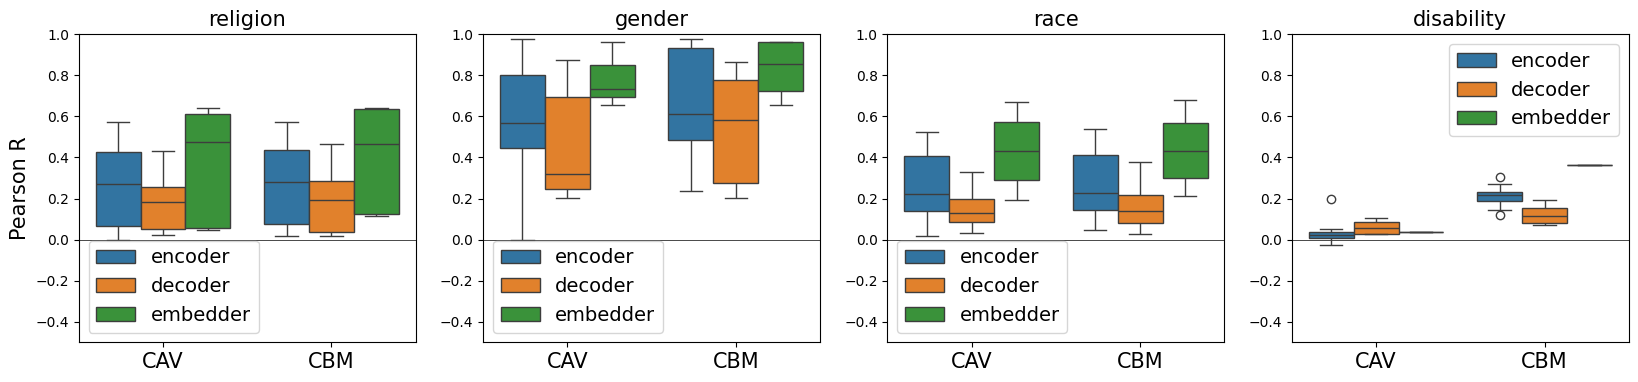

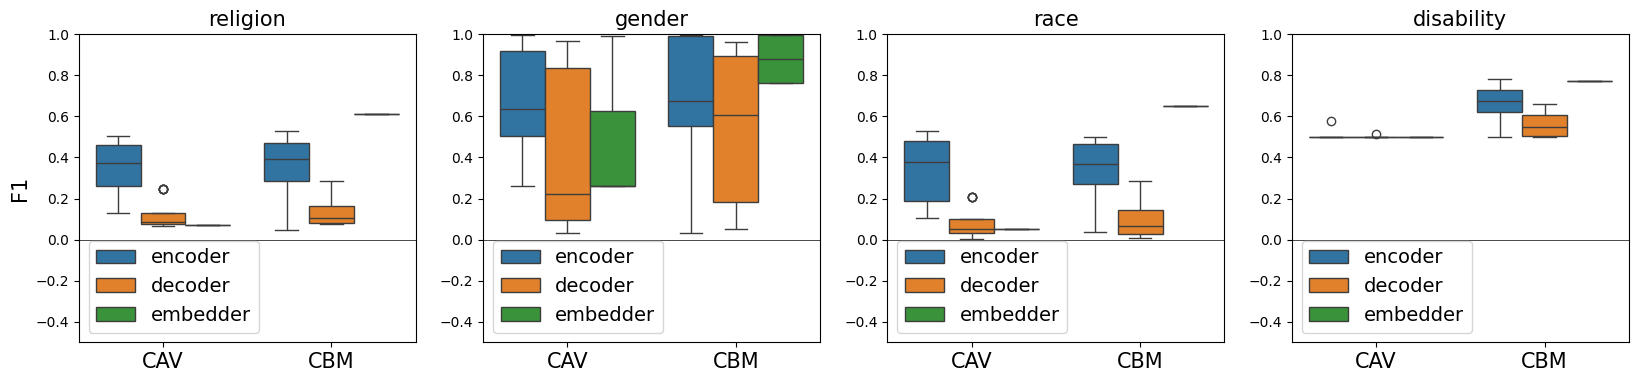

In [16]:
res_cl_same_dataset = res_cl[res_cl['dataset (train)'] == res_cl['dataset (eval)']]

multipot(res_cl_same_dataset, subplot_col='protected_attr', xcol='method', ycol='Pearson R', huecol='model_architecture', remove_legend=False)
multipot(res_cl_same_dataset, subplot_col='protected_attr', xcol='method', ycol='F1', huecol='model_architecture', remove_legend=False)

### b) Cross-dataset transfer

In [17]:
gres_transfer = gres[gres['exp'] == 'transfer']

# summarize results per dataset and transfer/ non transfer
res_per_dataset_transfer = aggregate_results(gres_transfer, ['exp', 'dataset (eval)', 'method'], 'F1')
res_per_dataset_transfer

,index,exp,dataset (eval),method,F1,F1 var
0,0,transfer,bios-supervised,CAV,0.450618,0.110836
1,1,transfer,bios-supervised,CBM,0.108256,0.003987
2,2,transfer,crows_pairs,CAV,0.367223,0.043235
3,3,transfer,crows_pairs,CBM,0.448214,0.058947
4,4,transfer,jigsaw,CAV,0.230089,0.025037
5,5,transfer,jigsaw,CBM,0.223697,0.003556
6,6,transfer,twitterAAE,CAV,0.083277,0.015654
7,7,transfer,twitterAAE,CBM,0.004724,0.000048


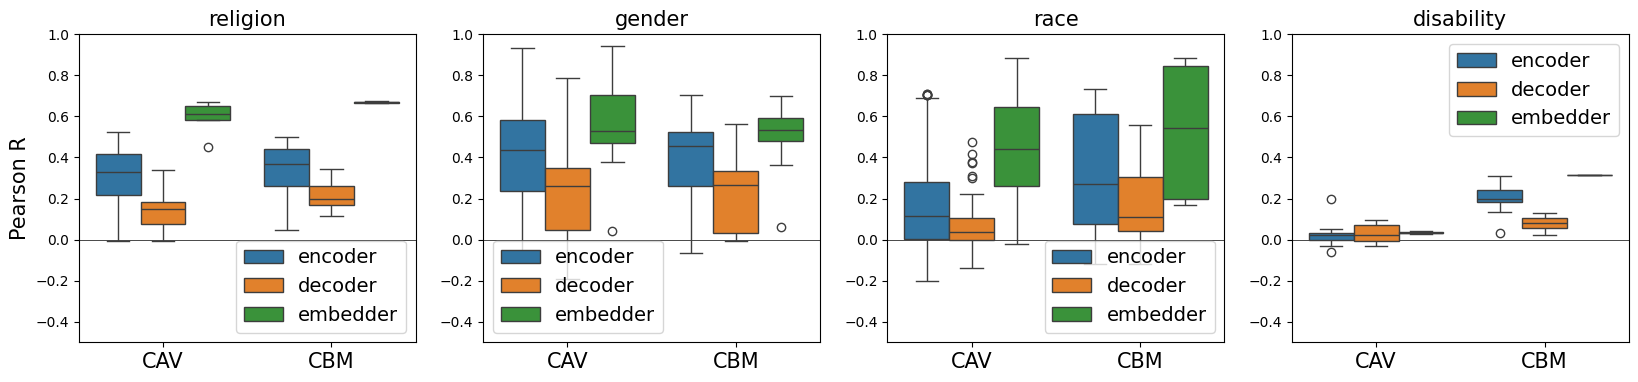

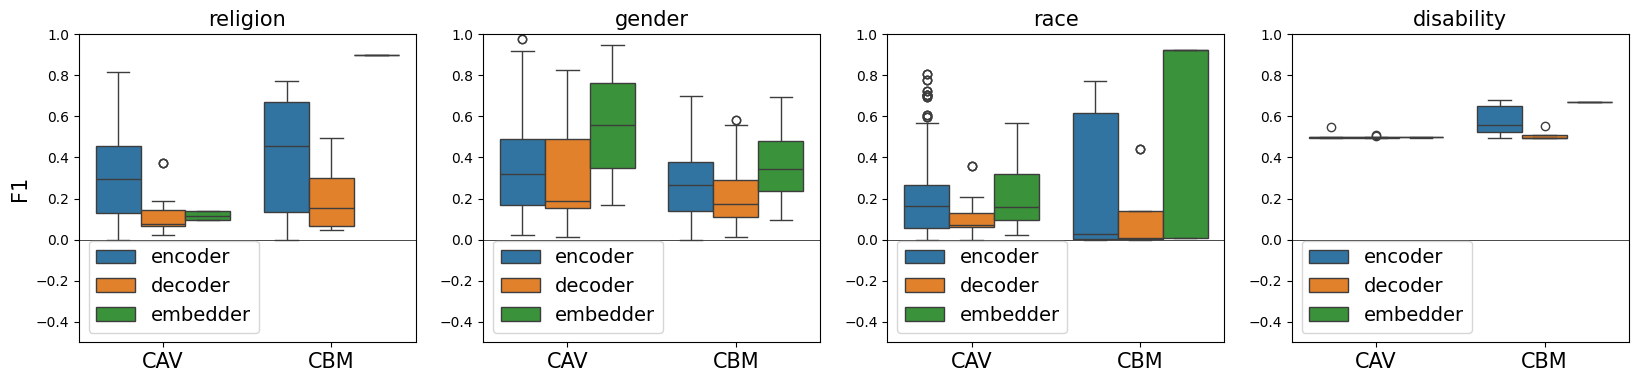

In [18]:
res_cl_transfer = res_cl[res_cl['dataset (train)'] != res_cl['dataset (eval)']]

multipot(res_cl_transfer, subplot_col='protected_attr', xcol='method', ycol='Pearson R', huecol='model_architecture', remove_legend=False)
multipot(res_cl_transfer, subplot_col='protected_attr', xcol='method', ycol='F1', huecol='model_architecture', remove_legend=False)

## 2) Evaluating Bias Space for Concept Retrieval

Comparing Pearson Correlation of Bias Space concepts with CBM and CAV.

### a) Overview over protected attributes.

In [19]:
res_all.columns

Index(['index', 'protected_attr', 'dataset (train)', 'dataset (eval)',
       'embedder', 'pooling', 'group (test)', 'concept (train)', 'F1',
       'Pearson R', 'Pearson p', 'method', 'model_type', 'model_architecture',
       'emb_size'],
      dtype='object')

In [20]:
# aggregate results over groups of the same experiment setup
gres = aggregate_results(res_all, ['protected_attr', 'dataset (train)', 'dataset (eval)', 'embedder', 'pooling', 'method', 'model_architecture', 'model_type', 'emb_size'], 'Pearson R')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


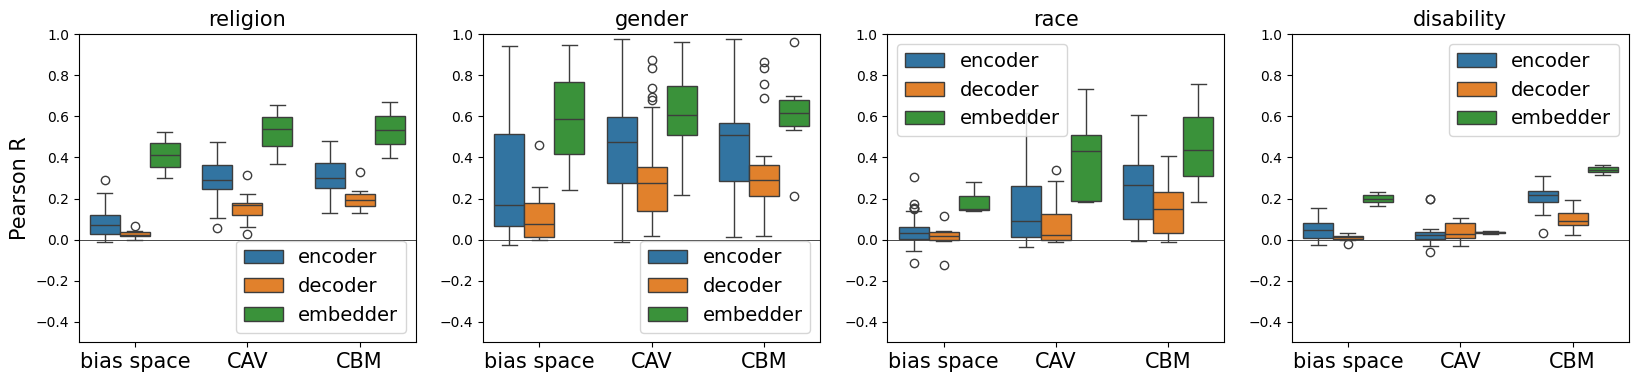

In [21]:
multipot(gres, subplot_col='protected_attr', xcol='method', ycol='Pearson R', huecol='model_architecture', remove_legend=False, savefile='plots/esann25/corr.eps')

### b) Overview over datasets (one plot per attribute)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.



religion


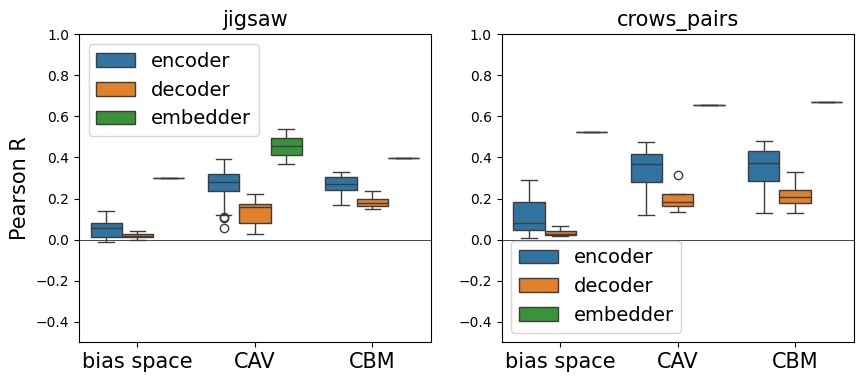


gender


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


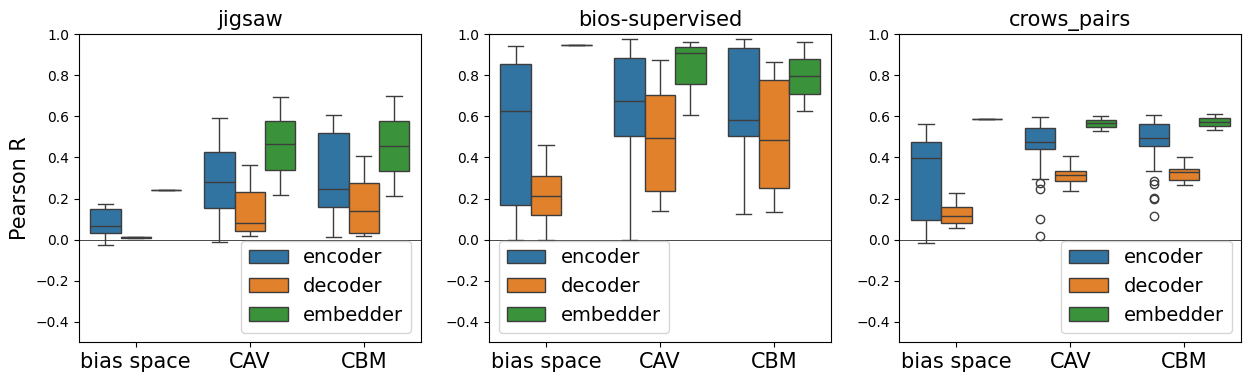


race


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


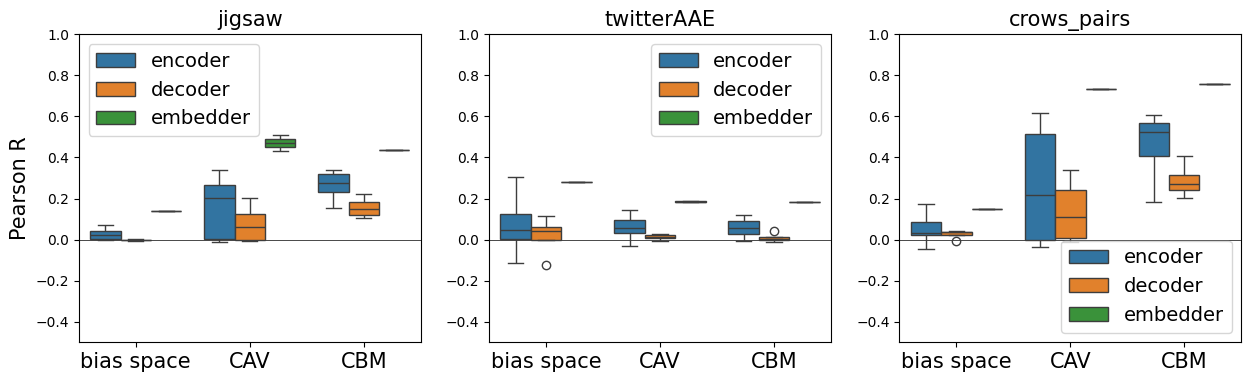

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.



disability


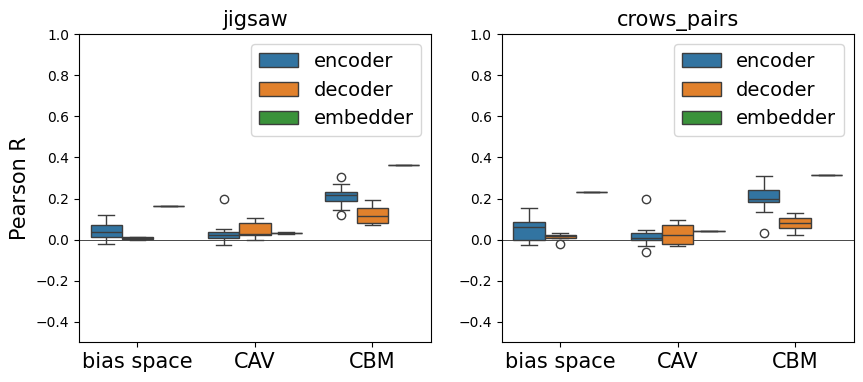

In [22]:
protected_attr = list(set(gres['protected_attr']))
for attr in protected_attr:
    print()
    print(attr)
    res_filt = gres[gres['protected_attr'] == attr]
    multipot(res_filt, subplot_col='dataset (eval)', xcol='method', ycol='Pearson R', huecol='model_architecture', remove_legend=False, savefile=('plots/esann25/corr_%s.eps' % attr))